In [1]:
# data comes from http://web.stanford.edu/~ericyi/project_page/part_annotation/index.html
from pyntcloud import PyntCloud
from matplotlib import pyplot as plt
%matplotlib inline

import sys
import os
if sys.platform == 'darwin':
    data_path = os.getcwd() + "/PartAnnotation"
else:
    data_path = os.getcwd() + "\\PartAnnotation"

In [2]:
data_path

'/Users/shijian/git/3D-CNN/3d_pointcloud/PartAnnotation'

In [3]:
import pandas as pd

def count_data(data_path):
    res = {}
    for entry in os.scandir(data_path):
        if entry.is_dir():
            for pts_data in os.scandir(os.path.join(data_path, entry.name, 'points')):
                if entry.name in res:
                    res.update({entry.name: res.get(entry.name) + 1})
                else:
                    res.update({entry.name: 1})
    return pd.DataFrame.from_dict(res, orient='index')

In [4]:
x = count_data(data_path)

(array([ 11.,   0.,   1.,   0.,   1.,   0.,   0.,   1.,   1.,   1.]),
 array([   56. ,   901.3,  1746.6,  2591.9,  3437.2,  4282.5,  5127.8,
         5973.1,  6818.4,  7663.7,  8509. ]),
 <a list of 10 Patch objects>)

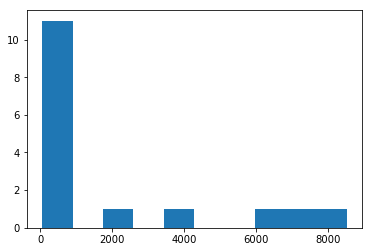

In [5]:
plt.hist(x)

In [6]:
def find_data(data_path):
    data = []
    label = []
    for entry in os.scandir(data_path):
        if entry.is_dir():
            for pts_data in os.scandir(os.path.join(data_path, entry.name, 'points')):
                data.append(os.path.join(data_path, entry.name, 'points', pts_data.name))
                label.append(entry.name)
    return data, label

In [7]:
data, label = find_data(data_path)

In [8]:
my_point_cloud = PyntCloud.from_file(data[1000], sep=" ", header=0, names=["x","y","z"])

In [29]:
label[1000]

'lamp'

In [30]:
my_point_cloud.add_structure("voxelgrid", x_y_z=[32, 32, 32])

my_point_cloud.plot(point_size=0.01)

In [10]:
import math
import numpy as np

def voxelize3D(pts, dim=[1,1,1]):
    """
    pts: receives .pts cloud point data. 2D array, arbitary sized X,Y,Z pairs.
    dim: dimensioin of output voxelized data
    
    .pts data X, Y, Z ranged from -0.5~0.5.
    This function will locate the grid cube and calculate the density of each cube.
    """
    assert(pts.shape[1]==3)
    assert(len(dim)==3)
    
    x_grid_length = 1/dim[0]
    y_grid_length = 1/dim[1]
    z_grid_length = 1/dim[2]
    
    output = np.zeros((dim[0],dim[1],dim[2])) # Make a 10 by 20 by 30 array
    
    for pair in pts:
        x_loc = int(pair[0]/x_grid_length) + int(dim[0]/2)
        y_loc = int(pair[1]/y_grid_length) + int(dim[1]/2)
        z_loc = int(pair[2]/z_grid_length) + int(dim[2]/2)
        if output[x_loc, y_loc, z_loc] is None:
            output[x_loc, y_loc, z_loc] = 1
        else:
            output[x_loc, y_loc, z_loc] += 1
            
    return output

In [11]:
# %load ./voxel_grid_plot.py
import os
import shutil

import numpy as np

from IPython.display import IFrame
from matplotlib import pyplot as plt


def plot_voxelgrid(voxelgrid,
                   output_name=None,
                   cmap="Oranges",
                   axis=True,
                   width=800,
                   height=600):

    scaled_shape = voxelgrid.shape

    vector = voxelgrid
    points = np.argwhere(vector) * scaled_shape

    s_m = plt.cm.ScalarMappable(cmap=cmap)
    rgb = s_m.to_rgba(vector.reshape(-1)[vector.reshape(-1) > 0])

    camera_position = points.max(0) + abs(points.max(0))

    look = points.mean(0)

    if axis:
        axis_size = points.ptp() * 1.5
    else:
        axis_size = 0

    placeholders = {}

    placeholders["POINTS_X_PLACEHOLDER"] = points[:, 0].tolist()
    placeholders["POINTS_Y_PLACEHOLDER"] = points[:, 1].tolist()
    placeholders["POINTS_Z_PLACEHOLDER"] = points[:, 2].tolist()

    placeholders["R_PLACEHOLDER"] = rgb[:, 0].tolist()
    placeholders["G_PLACEHOLDER"] = rgb[:, 1].tolist()
    placeholders["B_PLACEHOLDER"] = rgb[:, 2].tolist()

    placeholders["S_x_PLACEHOLDER"] = scaled_shape[0]
    placeholders["S_y_PLACEHOLDER"] = scaled_shape[1]
    placeholders["S_z_PLACEHOLDER"] = scaled_shape[2]

    placeholders["CAMERA_X_PLACEHOLDER"] = camera_position[0]
    placeholders["CAMERA_Y_PLACEHOLDER"] = camera_position[1]
    placeholders["CAMERA_Z_PLACEHOLDER"] = camera_position[2]

    placeholders["LOOK_X_PLACEHOLDER"] = look[0]
    placeholders["LOOK_Y_PLACEHOLDER"] = look[1]
    placeholders["LOOK_Z_PLACEHOLDER"] = look[2]

    placeholders["AXIS_SIZE_PLACEHOLDER"] = axis_size

    placeholders["N_VOXELS_PLACEHOLDER"] = sum(vector.reshape(-1) > 0)

    if output_name is None:
        output_name = "plotVG.html"

    BASE_PATH = os.getcwd()
    src = "{}/{}".format(BASE_PATH, "voxelgrid.html")
    dst = "{}/{}".format(os.getcwd(), output_name)

    with open(src, "r") as inp, open(dst, "w") as out:
        for line in inp:
            for key, val in placeholders.items():
                if key in line:
                    line = line.replace(key, str(val))
            out.write(line)

    return IFrame(output_name, width=width, height=height)

In [31]:
plot_voxelgrid(vox)

In [12]:
# one-hot
cate = []
for l in label:
    if l not in cate:
        cate.append(l)

onehot = []
for l in label:
    x = np.zeros(len(cate))
    x[cate.index(cate[0])] = 1.0
    onehot.append(x)
    
y_train = onehot

In [13]:
x_train = []
for i in range(100):
    my_point_cloud = PyntCloud.from_file(data[i], sep=" ", header=0, names=["x","y","z"])
    vox = voxelize3D(my_point_cloud.xyz, [32,32,32])
    vox_chan = np.array(vox).reshape(vox.shape + (1,))
    x_train.append(vox_chan)

In [14]:
x_train[0].shape

(32, 32, 32, 1)

In [15]:
import tensorflow as tf

with tf.name_scope('inputs'):
    x_input = tf.placeholder(tf.float32, shape=[None, 32, 32, 32, 1])
    y_input = tf.placeholder(tf.float32, shape=[None, len(cate)]) 

In [19]:
def cnn_model(x_train_data, label_size, keep_rate=0.7, seed=None):
    
    with tf.name_scope("layer_a"):
        # conv => 32*32*32
        conv1 = tf.layers.conv3d(inputs=x_train_data, filters=16, kernel_size=[3,3,3], padding='same', activation=tf.nn.relu)
        # conv => 32*32*32
        conv2 = tf.layers.conv3d(inputs=conv1, filters=32, kernel_size=[3,3,3], padding='same', activation=tf.nn.relu)
        # pool => 16*16*16
        pool3 = tf.layers.max_pooling3d(inputs=conv2, pool_size=[2, 2, 2], strides=2)
        
    with tf.name_scope("layer_b"):
        # conv => 16*16*16
        conv4 = tf.layers.conv3d(inputs=pool3, filters=64, kernel_size=[3,3,3], padding='same', activation=tf.nn.relu)
        # conv => 16*16*16
        conv5 = tf.layers.conv3d(inputs=conv4, filters=128, kernel_size=[3,3,3], padding='same', activation=tf.nn.relu)
        # pool => 8*8*8
        pool6 = tf.layers.max_pooling3d(inputs=conv5, pool_size=[2, 2, 2], strides=2)
        
    with tf.name_scope("layer_c"):
        # conv => 8*8*8
        conv7 = tf.layers.conv3d(inputs=pool6, filters=256, kernel_size=[3,3,3], padding='same', activation=tf.nn.relu)
        # conv => 8*8*8
        conv8 = tf.layers.conv3d(inputs=conv7, filters=512, kernel_size=[3,3,3], padding='same', activation=tf.nn.relu)
        # pool => 4*4*4
        pool9 = tf.layers.max_pooling3d(inputs=conv8, pool_size=[2, 2, 2], strides=2)
        
    with tf.name_scope("batch_norm"):
        cnn3d_bn = tf.layers.batch_normalization(inputs=pool9, training=True)
        
    with tf.name_scope("fully_con"):
        flattening = tf.reshape(cnn3d_bn, [-1, 4*4*4*512])
        dense = tf.layers.dense(inputs=flattening, units=1024, activation=tf.nn.relu)
        # (1-keep_rate) is the probability that the node will be kept
        dropout = tf.layers.dropout(inputs=dense, rate=keep_rate, training=True)
        
    with tf.name_scope("y_conv"):
        y_conv = tf.layers.dense(inputs=dropout, units=label_size)
    
    return y_conv

In [26]:
def train_neural_network(x_train_data, y_train_data, x_test_data, y_test_data, learning_rate=0.1, keep_rate=0.7, epochs=10, batch_size=128, using_gpu=False):

    if using_gpu:
        device_name = '/gpu:1' 
    else:
        device_name = '/cpu:0'

    with tf.device(device_name):
        with tf.name_scope("cross_entropy"):
            prediction = cnn_model(x_input, len(cate), keep_rate, seed=1)
            cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y_input))
                              
        with tf.name_scope("training"):
            optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

        correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y_input, 1))
        accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
        
    sess = tf.Session()
   
    if using_gpu:
        # GPU using BFC
        config = tf.ConfigProto()
        config.gpu_options.allocator_type = 'BFC'
        sess =  tf.Session(config= config)
            
    sess.run(tf.global_variables_initializer())
    import datetime

    start_time = datetime.datetime.now()

    iterations = int(len(x_train_data)/batch_size) + 1
    # run epochs
    for epoch in range(epochs):
        start_time_epoch = datetime.datetime.now()
        print('Epoch', epoch, 'started', end='')
        epoch_loss = 0
        # mini batch
        for itr in range(iterations):
            mini_batch_x = x_train_data[itr*batch_size: (itr+1)*batch_size]
            mini_batch_y = y_train_data[itr*batch_size: (itr+1)*batch_size]
            _optimizer, _cost = sess.run([optimizer, cost], feed_dict={x_input: mini_batch_x, y_input: mini_batch_y})
            epoch_loss += _cost

        acc = sess.run(accuracy, feed_dict={x_input: x_test_data, y_input: y_test_data})
        
        end_time_epoch = datetime.datetime.now()
        print(' Testing Set Accuracy:',acc, ' Time elapse: ', str(end_time_epoch - start_time_epoch))

    end_time = datetime.datetime.now()
    print('Time elapse: ', str(end_time - start_time))
    sess.close()

In [27]:
train_neural_network(x_train[:10], y_train[:10], x_train[:10], y_train[:10], learning_rate=0.01, batch_size=32, epochs=50, using_gpu=False)

Epoch 0 started Testing Set Accuracy: 1.0  Time elapse:  0:01:42.212694
Epoch 1 started Testing Set Accuracy: 1.0  Time elapse:  0:01:43.092038
Epoch 2 started

KeyboardInterrupt: 